In [1]:
from __future__ import absolute_import
from keras_unet_collection.layer_utils import *
from keras_unet_collection.activations import GELU, Snake
from keras_unet_collection._backbone_zoo import backbone_zoo, bach_norm_checker
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
import os
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import ReLU, LeakyReLU, ELU, PReLU
from tensorflow.keras.layers import Input
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

In [2]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = K.argmax(y_true, axis=-1)

    y_pred = tf.one_hot(y_pred, depth=N_CLASSES, dtype=tf.float32)
    y_true = tf.one_hot(y_true, depth=N_CLASSES, dtype=tf.float32)

    y_pred_f = K.flatten(y_pred)
    y_true_f = K.flatten(y_true)

    intersection = K.sum(y_pred_f * y_true_f)
    return (2. * intersection + smooth) / (K.sum(y_pred_f) + K.sum(y_true_f) + smooth)

    
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def categorical_dice_loss(y_true, y_pred):
    # Usa tf.shape para obtener la dimensión en tiempo de ejecución
    num_classes = tf.shape(y_pred)[-1]
    dice = 0.0
    for i in tf.range(num_classes):
        dice += dice_loss(y_true[..., i], y_pred[..., i])
    return dice / tf.cast(num_classes, tf.float32)

def combo_loss(y_true, y_pred, alpha=0.5):
    cce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    dice = categorical_dice_loss(y_true, y_pred)
    return alpha * cce + (1 - alpha) * dice

def mean_iou(y_true, y_pred, smooth=1e-6):
    # Convierte a etiquetas (clases)
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = K.argmax(y_true, axis=-1)

    ious = []
    for i in range(N_CLASSES):
        pred_i = K.cast(K.equal(y_pred, i), 'float32')
        true_i = K.cast(K.equal(y_true, i), 'float32')

        intersection = K.sum(pred_i * true_i)
        union = K.sum(pred_i) + K.sum(true_i) - intersection

        iou = (intersection + smooth) / (union + smooth)
        ious.append(iou)

    return K.mean(tf.stack(ious))



In [3]:
def UNET_left(X, channel, kernel_size=3, stack_num=2, activation='ReLU', 
              pool=True, batch_norm=False, name='left0'):
    pool_size = 2
    X = encode_layer(X, channel, pool_size, pool, activation=activation, 
                     batch_norm=batch_norm, name='{}_encode'.format(name))
    X = CONV_stack(X, channel, kernel_size, stack_num=stack_num, activation=activation, 
                   batch_norm=batch_norm, name='{}_conv'.format(name))
    return X


def UNET_right(X, X_list, channel, kernel_size=3, 
               stack_num=2, activation='ReLU',
               unpool=True, batch_norm=False, concat=True, name='right0'):
    pool_size = 2
    X = decode_layer(X, channel, pool_size, unpool, 
                     activation=activation, batch_norm=batch_norm, name='{}_decode'.format(name))
    X = CONV_stack(X, channel, kernel_size, stack_num=1, activation=activation, 
                   batch_norm=batch_norm, name='{}_conv_before_concat'.format(name))
    if concat:
        X = concatenate([X,]+X_list, axis=3, name=name+'_concat')
    X = CONV_stack(X, channel, kernel_size, stack_num=stack_num, activation=activation, 
                   batch_norm=batch_norm, name=name+'_conv_after_concat')
    return X

def unet_2d_base(input_tensor, filter_num, stack_num_down=2, stack_num_up=2, 
                 activation='ReLU', batch_norm=False, pool=True, unpool=True, 
                 backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='unet'):
    activation_func = eval(activation)
    X_skip = []
    depth_ = len(filter_num)
    if backbone is None:
        X = input_tensor
        X = CONV_stack(X, filter_num[0], stack_num=stack_num_down, activation=activation, 
                       batch_norm=batch_norm, name='{}_down0'.format(name))
        X_skip.append(X)
        for i, f in enumerate(filter_num[1:]):
            X = UNET_left(X, f, stack_num=stack_num_down, activation=activation, pool=pool, 
                          batch_norm=batch_norm, name='{}_down{}'.format(name, i+1))        
            X_skip.append(X)
    else:
        if 'VGG' in backbone:
            backbone_ = backbone_zoo(backbone, weights, input_tensor, depth_, freeze_backbone, freeze_batch_norm)
            X_skip = backbone_([input_tensor,])
            depth_encode = len(X_skip)
        else:
            backbone_ = backbone_zoo(backbone, weights, input_tensor, depth_-1, freeze_backbone, freeze_batch_norm)
            X_skip = backbone_([input_tensor,])
            depth_encode = len(X_skip) + 1

        if depth_encode < depth_:
            X = X_skip[-1]
            for i in range(depth_-depth_encode):
                i_real = i + depth_encode
                X = UNET_left(X, filter_num[i_real], stack_num=stack_num_down, activation=activation, pool=pool, 
                              batch_norm=batch_norm, name='{}_down{}'.format(name, i_real+1))
                X_skip.append(X)

    
    X_skip = X_skip[::-1] # reverse indexing encoded feature maps
    X = X_skip[0]  # upsampling begins at the deepest available tensor
    X_decode = X_skip[1:]     # other tensors are preserved for concatenation
    depth_decode = len(X_decode)
    filter_num_decode = filter_num[:-1][::-1]     # reverse indexing filter numbers
    for i in range(depth_decode):
        X = UNET_right(X, [X_decode[i],], filter_num_decode[i], stack_num=stack_num_up, activation=activation, 
                       unpool=unpool, batch_norm=batch_norm, name='{}_up{}'.format(name, i))

    if depth_decode < depth_-1:
        for i in range(depth_-depth_decode-1):
            i_real = i + depth_decode
            X = UNET_right(X, None, filter_num_decode[i_real], stack_num=stack_num_up, activation=activation, 
                       unpool=unpool, batch_norm=batch_norm, concat=False, name='{}_up{}'.format(name, i_real))   
    return X

def unet_2d(input_size, filter_num, n_labels, stack_num_down=2, stack_num_up=2,
            activation='ReLU', output_activation='Softmax', batch_norm=False, pool=True, unpool=True, 
            backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='unet'):
    activation_func = eval(activation)
    if backbone is not None:
        bach_norm_checker(backbone, batch_norm)
    IN = Input(input_size)
    X = unet_2d_base(IN, filter_num, stack_num_down=stack_num_down, stack_num_up=stack_num_up, 
                     activation=activation, batch_norm=batch_norm, pool=pool, unpool=unpool, 
                     backbone=backbone, weights=weights, freeze_backbone=freeze_backbone, 
                     freeze_batch_norm=freeze_backbone, name=name)
    OUT = CONV_output(X, n_labels, kernel_size=1, activation=output_activation, name='{}_output'.format(name))
    model = Model(inputs=[IN,], outputs=[OUT,], name='{}_model'.format(name))
    return model

In [4]:
# Imagen reescalada (más liviana para tu RTX 3050)
IMG_SIZE = (128, 128)

# Número de clases incluyendo fondo
N_CLASSES = 9

# Tamaños por nivel (U-Net reducida)
FILTER_NUM = [64, 128, 256, 512, 1024]

# Batch size bajo por límite de VRAM
BATCH_SIZE = 2

color_to_class = {
    (0, 0, 0): 0,         # fondo
    (100, 0, 100): 1,     # hígado (violeta oscuro)
    (255, 255, 0): 2,     # riñón (amarillo)
    (0, 0, 255): 3,       # páncreas (azul)
    (255, 0, 0): 4,       # vasos (rojo)
    (0, 255, 255): 5,     # suprarrenales (celeste)
    (0, 255, 0): 6,       # vesícula (verde)
    (255, 255, 255): 7,   # huesos (blanco)
    (255, 0, 255): 8      # bazo (rosado)
}
def rgb_mask_to_class(mask_rgb):
    h, w, _ = mask_rgb.shape
    mask_class = np.zeros((h, w), dtype=np.uint8)

    for color, class_id in color_to_class.items():
        matches = np.all(mask_rgb == color, axis=-1)
        mask_class[matches] = class_id

    return mask_class

class UltrasoundDataset(Sequence):
    def __init__(self, file_list, img_dir, mask_dir, batch_size=2, img_size=(128,128), n_classes=9):
        self.file_list = file_list
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.n_classes = n_classes

    def __len__(self):
        return int(np.ceil(len(self.file_list) / self.batch_size))

    def __getitem__(self, idx):
        batch_files = self.file_list[idx*self.batch_size : (idx+1)*self.batch_size]
        batch_x, batch_y = [], []

        for fname in batch_files:
            # Imagen
            img = cv2.imread(os.path.join(self.img_dir, fname), cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, self.img_size)
            img = img.astype(np.float32) / 255.0
            img = np.expand_dims(img, axis=-1)

            # Máscara
            mask_name = fname.replace("resized_", "")
            mask = cv2.imread(os.path.join(self.mask_dir, mask_name))
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            mask = cv2.resize(mask, self.img_size, interpolation=cv2.INTER_NEAREST)
            mask_class = rgb_mask_to_class(mask)
            mask_one_hot = to_categorical(mask_class, num_classes=self.n_classes)

            batch_x.append(img)
            batch_y.append(mask_one_hot)

        return np.array(batch_x), np.array(batch_y)

In [5]:
BASE_PATH = "archive/abdominal_US/AUS"
IMG_DIR = "fakeRUS_train_cartesian"
MASK_DIR = os.path.join(BASE_PATH, "annotations/train")

# Lista de archivos y split
all_files = sorted([f for f in os.listdir(IMG_DIR) if f.endswith(".png")])
train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)

# Generadores
train_gen = UltrasoundDataset(train_files, IMG_DIR, MASK_DIR, batch_size=BATCH_SIZE, img_size=IMG_SIZE, n_classes=N_CLASSES)
val_gen = UltrasoundDataset(val_files, IMG_DIR, MASK_DIR, batch_size=BATCH_SIZE, img_size=IMG_SIZE, n_classes=N_CLASSES)

model = unet_2d(
    input_size=(IMG_SIZE[0], IMG_SIZE[1], 1),
    filter_num=FILTER_NUM,
    n_labels=N_CLASSES,
    stack_num_down=2,
    stack_num_up=2,
    activation='ReLU',
    output_activation='Softmax',
    batch_norm=True,
    pool=True,
    unpool=True,
    backbone=None
)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
callbacks = [
    ModelCheckpoint("best_multiclass_model2.h5", save_best_only=True, monitor="val_loss"),
    EarlyStopping(patience=50, restore_best_weights=True),
    ReduceLROnPlateau(patience=5, factor=0.5)
]

In [24]:
tf.debugging.set_log_device_placement(True)
model.fit(train_gen, validation_data=val_gen, epochs=300, callbacks=callbacks)

Epoch 1/300
252/252 [==============================] - 32s 111ms/step - loss: 0.5812 - accuracy: 0.8157 - val_loss: 1.3446 - val_accuracy: 0.1991 - lr: 0.0010
Epoch 2/300
252/252 [==============================] - 27s 105ms/step - loss: 0.4824 - accuracy: 0.8318 - val_loss: 1.0262 - val_accuracy: 0.3725 - lr: 0.0010
Epoch 3/300
252/252 [==============================] - 27s 107ms/step - loss: 0.4700 - accuracy: 0.8350 - val_loss: 0.6269 - val_accuracy: 0.7549 - lr: 0.0010
Epoch 4/300
252/252 [==============================] - 28s 113ms/step - loss: 0.4581 - accuracy: 0.8377 - val_loss: 0.5429 - val_accuracy: 0.8247 - lr: 0.0010
Epoch 5/300
252/252 [==============================] - 26s 101ms/step - loss: 0.4454 - accuracy: 0.8427 - val_loss: 0.9831 - val_accuracy: 0.6912 - lr: 0.0010
Epoch 6/300
252/252 [==============================] - 28s 111ms/step - loss: 0.4370 - accuracy: 0.8449 - val_loss: 0.4078 - val_accuracy: 0.8582 - lr: 0.0010
Epoch 7/300
252/252 [=========================

In [5]:
class_to_color = {
    0: (0, 0, 0),           # fondo
    1: (100, 0, 100),       # hígado (violeta oscuro)
    2: (255, 255, 0),       # riñón (amarillo)
    3: (0, 0, 255),         # páncreas (azul)
    4: (255, 0, 0),         # vasos (rojo)
    5: (0, 255, 255),       # suprarrenales (celeste)
    6: (0, 255, 0),         # vesícula (verde)
    7: (255, 255, 255),     # huesos (blanco)
    8: (255, 0, 255),       # bazo (rosado)
}
def mask_class_to_rgb(mask_class):
    h, w = mask_class.shape
    rgb_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for class_id, color in class_to_color.items():
        rgb_mask[mask_class == class_id] = color
    return rgb_mask

In [6]:
model = load_model("best_multiclass_model2.h5")

1/1 [==============================] - 12s 12s/step


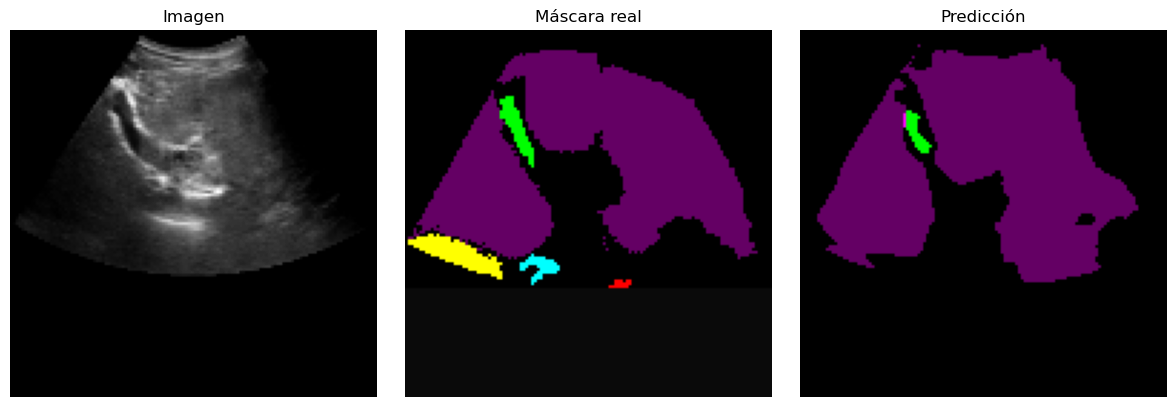

In [7]:
IMG_DIR = "fakeRUS_cartesian"
MASK_DIR = "archive/abdominal_US/AUS/annotations/test"

# 📸 Selecciona un archivo
fname = "resized_ct1-69.png"  # <- cámbialo si quieres otra imagen

# === 1. Cargar imagen
img = cv2.imread(os.path.join(IMG_DIR, fname), cv2.IMREAD_GRAYSCALE)
img_resized = cv2.resize(img, (128, 128))
img_norm = img_resized.astype(np.float32) / 255.0
img_input = np.expand_dims(img_norm, axis=(0, -1))  # (1, 128, 128, 1)

# === 2. Cargar máscara real
mask_name = fname.replace("resized_", "")
mask_rgb = cv2.imread(os.path.join(MASK_DIR, mask_name))
mask_rgb = cv2.cvtColor(mask_rgb, cv2.COLOR_BGR2RGB)
mask_rgb_resized = cv2.resize(mask_rgb, (128, 128), interpolation=cv2.INTER_NEAREST)

# === 3. Predicción
pred = model.predict(img_input)[0]  # (128, 128, 9)
pred_class = np.argmax(pred, axis=-1)  # (128, 128)
pred_rgb = mask_class_to_rgb(pred_class)

# === 4. Visualización
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Imagen")
plt.imshow(img_resized, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Máscara real")
plt.imshow(mask_rgb_resized)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Predicción")
plt.imshow(pred_rgb)
plt.axis('off')

plt.tight_layout()
plt.show()

In [51]:
cv2.imwrite("pred_" + fname.replace("resized_", ""), cv2.cvtColor(pred_rgb, cv2.COLOR_RGB2BGR))

True

In [50]:
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score

# Convertir la máscara real RGB a clases
mask_rgb_class = rgb_mask_to_class(mask_rgb_resized)
y_true_flat = mask_rgb_class.flatten()

# Predicción ya la tienes como pred_class
y_pred_flat = pred_class.flatten()

# Calcular métricas
dice = f1_score(y_true_flat, y_pred_flat, average='macro', zero_division=0)
iou = jaccard_score(y_true_flat, y_pred_flat, average='macro', zero_division=0)
precision = precision_score(y_true_flat, y_pred_flat, average='macro', zero_division=0)
recall = recall_score(y_true_flat, y_pred_flat, average='macro', zero_division=0)
f1 = f1_score(y_true_flat, y_pred_flat, average='macro', zero_division=0)

# Imprimir resultados
print(f"\n📊 Métricas para {fname}:")
print(f"Dice (DSC):     {dice:.4f}")
print(f"IoU (Jaccard):  {iou:.4f}")
print(f"Precision:      {precision:.4f}")
print(f"Recall:         {recall:.4f}")
print(f"F1‑Score:       {f1:.4f}")


📊 Métricas para resized_ct1-69.png:
Dice (DSC):     0.3334
IoU (Jaccard):  0.2799
Precision:      0.3672
Recall:         0.3187
F1‑Score:       0.3334


1/1 [==============================] - 0s 33ms/step


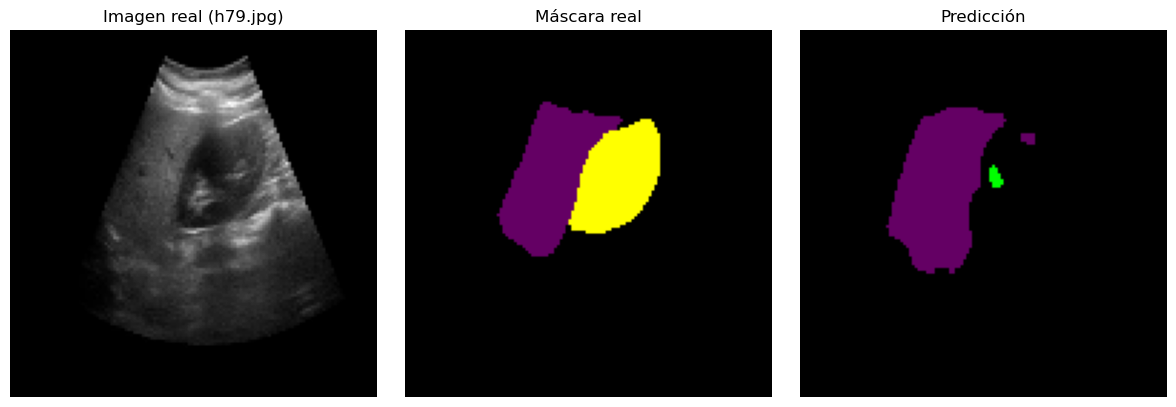

In [20]:
# === Rutas ===
real_img_path = "archive/abdominal_US/RUS/images/test/h79.jpg"
real_mask_path = "archive/abdominal_US/RUS/annotations/test/h79.png"

# === Leer imagen real (JPG) y convertir a PNG en memoria
img = cv2.imread(real_img_path, cv2.IMREAD_GRAYSCALE)
img_resized = cv2.resize(img, (128, 128))
img_norm = img_resized.astype(np.float32) / 255.0
img_input = np.expand_dims(img_norm, axis=(0, -1))  # (1, 128, 128, 1)

# === Leer máscara real (PNG)
mask = cv2.imread(real_mask_path)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
mask_resized = cv2.resize(mask, (128, 128), interpolation=cv2.INTER_NEAREST)

# === Predicción
pred = model.predict(img_input)[0]  # (128, 128, 9)
pred_class = np.argmax(pred, axis=-1)  # (128, 128)
pred_rgb = mask_class_to_rgb(pred_class)

# === Visualización
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Imagen real (h79.jpg)")
plt.imshow(img_resized, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Máscara real")
plt.imshow(mask_resized)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Predicción")
plt.imshow(pred_rgb)
plt.axis('off')

plt.tight_layout()
plt.show()


In [55]:
cv2.imwrite("pred_" + fname.replace("resized_", ""), cv2.cvtColor(pred_rgb, cv2.COLOR_RGB2BGR))

True

In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
import numpy as np
import os
import cv2
from tensorflow.keras.utils import to_categorical

# === Diccionario de colores
color_to_class = {
    (0, 0, 0): 0,
    (100, 0, 100): 1,
    (255, 255, 0): 2,
    (0, 0, 255): 3,
    (255, 0, 0): 4,
    (0, 255, 255): 5,
    (0, 255, 0): 6,
    (255, 255, 255): 7,
    (255, 0, 255): 8
}

def rgb_mask_to_class(mask_rgb):
    h, w, _ = mask_rgb.shape
    mask_class = np.zeros((h, w), dtype=np.uint8)
    for color, class_id in color_to_class.items():
        matches = np.all(mask_rgb == color, axis=-1)
        mask_class[matches] = class_id
    return mask_class

# === Dataset para test
class UltrasoundDatasetTest(tf.keras.utils.Sequence):
    def __init__(self, file_list, img_dir, mask_dir, batch_size=2, img_size=(128,128), n_classes=9):
        self.file_list = file_list
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.n_classes = n_classes

    def __len__(self):
        return int(np.ceil(len(self.file_list) / self.batch_size))

    def __getitem__(self, idx):
        batch_files = self.file_list[idx*self.batch_size : (idx+1)*self.batch_size]
        batch_x, batch_y = [], []

        for fname in batch_files:
            img = cv2.imread(os.path.join(self.img_dir, fname), cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, self.img_size)
            img = img.astype(np.float32) / 255.0
            img = np.expand_dims(img, axis=-1)

            # Corrige prefijos "resized_" y "rezized_"
            mask_name = fname
            if fname.startswith("resized_"):
                mask_name = fname[len("resized_"):]
            elif fname.startswith("rezized_"):
                mask_name = fname[len("rezized_"):]
            
            mask_path = os.path.join(self.mask_dir, mask_name)
            if not os.path.exists(mask_path):
                raise FileNotFoundError(f"Máscara no encontrada: {mask_path}")
            
            mask = cv2.imread(mask_path)
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            mask = cv2.resize(mask, self.img_size, interpolation=cv2.INTER_NEAREST)
            mask_class = rgb_mask_to_class(mask)
            mask_one_hot = to_categorical(mask_class, num_classes=self.n_classes)

            batch_x.append(img)
            batch_y.append(mask_one_hot)

        return np.array(batch_x), np.array(batch_y)

# === Función de evaluación
def evaluate_metrics_on_generator(model, generator):
    dice_list = []
    iou_list = []
    precision_list = []
    recall_list = []
    f1_list = []

    for X_batch, y_true_batch in generator:
        y_pred_batch = model.predict(X_batch)
        y_pred_labels = np.argmax(y_pred_batch, axis=-1).flatten()
        y_true_labels = np.argmax(y_true_batch, axis=-1).flatten()

        dice = f1_score(y_true_labels, y_pred_labels, average='macro', zero_division=0)
        iou = jaccard_score(y_true_labels, y_pred_labels, average='macro', zero_division=0)
        precision = precision_score(y_true_labels, y_pred_labels, average='macro', zero_division=0)
        recall = recall_score(y_true_labels, y_pred_labels, average='macro', zero_division=0)
        f1 = f1_score(y_true_labels, y_pred_labels, average='macro', zero_division=0)

        dice_list.append(dice)
        iou_list.append(iou)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

    results = {
        "Dice (DSC)": np.mean(dice_list),
        "IoU (Jaccard)": np.mean(iou_list),
        "Precision": np.mean(precision_list),
        "Recall": np.mean(recall_list),
        "F1‑Score": np.mean(f1_list),
    }

    return results

# === Evaluación
TEST_IMG_DIR = "fakeRUS_cartesian"
TEST_MASK_DIR = "archive/abdominal_US/AUS/annotations/test"
test_files = sorted([f for f in os.listdir(TEST_IMG_DIR) if f.endswith(".png")])
test_gen = UltrasoundDatasetTest(test_files, TEST_IMG_DIR, TEST_MASK_DIR)

results_test = evaluate_metrics_on_generator(model, test_gen)

print("📊 Métricas en el set de TEST (simulado - AUS transformado):")
for metric, value in results_test.items():
    print(f"{metric}: {value:.4f}")

1/1 [==============================] - 0s 32ms/step
📊 Métricas en el set de TEST (simulado - AUS transformado):
Dice (DSC): 0.2666
IoU (Jaccard): 0.2260
Precision: 0.3272
Recall: 0.2644
F1‑Score: 0.2666
